In [2]:
!pip install -q -U transformers[torch] datasets evaluate rouge_score gradio accelerate
print("Installation complete.")
import os

Installation complete.


In [1]:
import torch
from transformers import (
    pipeline,
    AutoTokenizer,
    AutoModelForSeq2SeqLM,
    Seq2SeqTrainingArguments,
    Seq2SeqTrainer,
    DataCollatorForSeq2Seq
)
from datasets import load_dataset
import evaluate
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import gradio as gr
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")
if device == "cpu":
    print("Running on CPU")

Device: cuda


In [13]:
print("Loading CNN/DailyMail dataset...")
dataset = load_dataset("cnn_dailymail", "3.0.0")
train_data = dataset['train'].shuffle(seed=42).select(range(1000))
test_data = dataset['test'].shuffle(seed=42).select(range(50))

metric = evaluate.load("rouge")

def evaluate_model(model_path, tokenizer_path=None):
    print(f"Evaluating {model_path}...")
    summarizer = pipeline("summarization", model=model_path, tokenizer=tokenizer_path or model_path, device=0 if device=="cuda" else -1)

    preds = []
    refs = []

    for i in tqdm(range(len(test_data))):
        text = test_data[i]['article'][:1024]
        try:
            res = summarizer(text, max_length=100, min_length=30, do_sample=False)
            preds.append(res[0]['summary_text'])
            refs.append(test_data[i]['highlights'])
        except:
            preds.append("")
            refs.append(test_data[i]['highlights'])

    scores = metric.compute(predictions=preds, references=refs)
    return scores

print("Baseline 1: T5-Small")
t5_base_scores = evaluate_model("t5-small")

print("Baseline 2: BART-Large")
bart_base_scores = evaluate_model("facebook/bart-large-cnn")

df_base = pd.DataFrame([t5_base_scores, bart_base_scores], index=["T5-Small (Base)", "BART-Large (Base)"])
print("\nBASELINE COMPARISON (Before Training):")
print(df_base[['rouge1', 'rouge2', 'rougeL']])


Loading CNN/DailyMail dataset...
Baseline 1: T5-Small
Evaluating t5-small...


Device set to use cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Baseline 2: BART-Large
Evaluating facebook/bart-large-cnn...


Device set to use cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]


BASELINE COMPARISON (Before Training):
                     rouge1    rouge2    rougeL
T5-Small (Base)    0.366269  0.152353  0.259251
BART-Large (Base)  0.395535  0.173578  0.275553


In [14]:
print("\nBASELINE COMPARISON (Before Training):")
print(df_base[['rouge1', 'rouge2', 'rougeL']])


BASELINE COMPARISON (Before Training):
                     rouge1    rouge2    rougeL
T5-Small (Base)    0.366269  0.152353  0.259251
BART-Large (Base)  0.395535  0.173578  0.275553


In [19]:
def train_model(model_id, output_name):
    print(f"\nSTARTING TRAINING FOR: {model_id}")

    tokenizer = AutoTokenizer.from_pretrained(model_id)
    model = AutoModelForSeq2SeqLM.from_pretrained(model_id)

    prefix = "summarize: " if "t5" in model_id else ""

    def preprocess_function(examples):
        inputs = [prefix + doc for doc in examples["article"]]
        model_inputs = tokenizer(inputs, max_length=512, truncation=True)
        labels = tokenizer(examples["highlights"], max_length=128, truncation=True)
        model_inputs["labels"] = labels["input_ids"]
        return model_inputs

    tokenized_train = train_data.map(preprocess_function, batched=True)
    tokenized_test = test_data.map(preprocess_function, batched=True)

    args = Seq2SeqTrainingArguments(
        output_dir=output_name,
        learning_rate=2e-5,
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        per_device_eval_batch_size=4,
        num_train_epochs=3,
        weight_decay=0.01,
        predict_with_generate=True,
        fp16=True if device=="cuda" else False,
        report_to="none",
        logging_steps=50,
        eval_strategy="steps",
        eval_steps=100,
        save_strategy="no"
    )

    trainer = Seq2SeqTrainer(
        model=model,
        args=args,
        train_dataset=tokenized_train,
        eval_dataset=tokenized_test,
        tokenizer=tokenizer,
        data_collator=DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model),
    )

    trainer.train()
    print(f"Finished training {model_id}")

    save_path = f"./fine_tuned_{output_name}"
    trainer.save_model(save_path)
    tokenizer.save_pretrained(save_path)
    return save_path


In [20]:
t5_save_path = train_model("t5-small", "t5_model")
bart_save_path = train_model("facebook/bart-large-cnn", "bart_model")


STARTING TRAINING FOR: t5-small


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/tmp/ipython-input-3403066438.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss,Validation Loss
100,2.283000,2.198874
200,2.141000,2.113563
300,2.082600,2.097483


Finished training t5-small

STARTING TRAINING FOR: facebook/bart-large-cnn


Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]

/tmp/ipython-input-3403066438.py:36: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


Step,Training Loss,Validation Loss
100,1.435200,1.682364
200,1.053800,1.772540
300,0.836500,1.888663


Finished training facebook/bart-large-cnn


/usr/local/lib/python3.12/dist-packages/transformers/modeling_utils.py:3918: UserWarning: Moving the following attributes in the config to the generation config: {'max_length': 142, 'min_length': 56, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


In [21]:
print("\nEVALUATING FINE-TUNED MODELS...")

t5_ft_scores = evaluate_model(t5_save_path)

bart_ft_scores = evaluate_model(bart_save_path)

all_results = [t5_base_scores, t5_ft_scores, bart_base_scores, bart_ft_scores]
indices = ["T5 (Base)", "T5 (Fine-Tuned)", "BART (Base)", "BART (Fine-Tuned)"]
df_leaderboard = pd.DataFrame(all_results, index=indices)

print("\nFINAL LEADERBOARD (Raw Scores):")
print(df_leaderboard[['rouge1', 'rouge2', 'rougeL']])

t5_delta = {k: t5_ft_scores[k] - t5_base_scores[k] for k in ['rouge1', 'rouge2', 'rougeL']}
bart_delta = {k: bart_ft_scores[k] - bart_base_scores[k] for k in ['rouge1', 'rouge2', 'rougeL']}

improvement_data = [
    {
        "Model": "T5",
        "Base ROUGE-1": t5_base_scores['rouge1'],
        "Fine-Tuned ROUGE-1": t5_ft_scores['rouge1'],
        "Improvement": t5_delta['rouge1']
    },
    {
        "Model": "BART",
        "Base ROUGE-1": bart_base_scores['rouge1'],
        "Fine-Tuned ROUGE-1": bart_ft_scores['rouge1'],
        "Improvement": bart_delta['rouge1']
    }
]

df_improvement = pd.DataFrame(improvement_data)
print("\nIMPROVEMENT ANALYSIS (Base vs Fine-Tuned):")
print(df_improvement.to_string(index=False))


EVALUATING FINE-TUNED MODELS...
Evaluating ./fine_tuned_t5_model...


Device set to use cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]

Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)
Both `max_new_tokens` (=256) and `max_length`(=100) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Evaluating ./fine_tuned_bart_model...


/usr/local/lib/python3.12/dist-packages/transformers/models/bart/configuration_bart.py:177: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(
Device set to use cuda:0


  0%|          | 0/50 [00:00<?, ?it/s]


FINAL LEADERBOARD (Raw Scores):
                     rouge1    rouge2    rougeL
T5 (Base)          0.366269  0.152353  0.259251
T5 (Fine-Tuned)    0.384670  0.163503  0.268375
BART (Base)        0.395535  0.173578  0.275553
BART (Fine-Tuned)  0.410015  0.179270  0.285584

IMPROVEMENT ANALYSIS (Base vs Fine-Tuned):
Model  Base ROUGE-1  Fine-Tuned ROUGE-1  Improvement
   T5      0.366269            0.384670     0.018401
 BART      0.395535            0.410015     0.014480


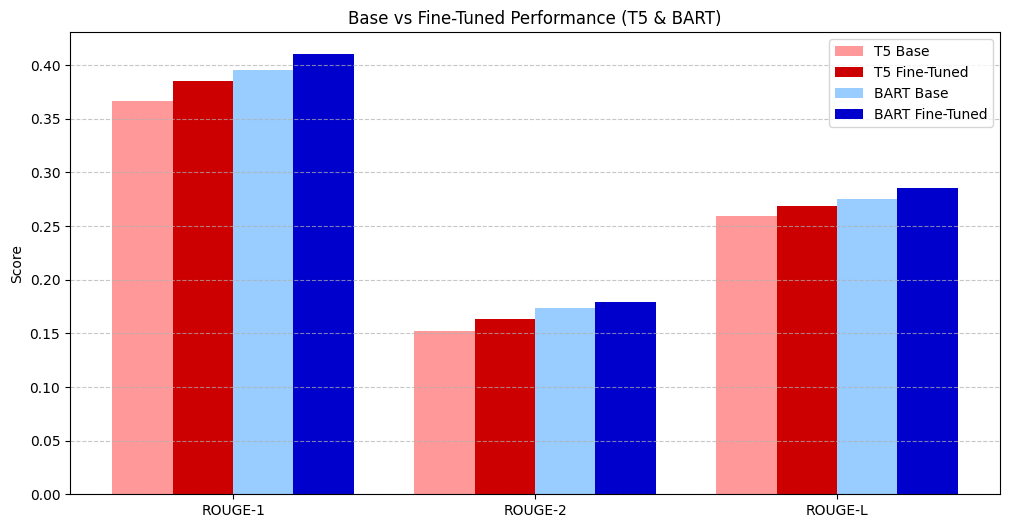

In [23]:
import matplotlib.pyplot as plt

labels = ['ROUGE-1', 'ROUGE-2', 'ROUGE-L']
t5_base_vals = [t5_base_scores[k] for k in ['rouge1', 'rouge2', 'rougeL']]
t5_ft_vals = [t5_ft_scores[k] for k in ['rouge1', 'rouge2', 'rougeL']]
bart_base_vals = [bart_base_scores[k] for k in ['rouge1', 'rouge2', 'rougeL']]
bart_ft_vals = [bart_ft_scores[k] for k in ['rouge1', 'rouge2', 'rougeL']]

x = np.arange(len(labels))
width = 0.2

fig, ax = plt.subplots(figsize=(12, 6))

rects1 = ax.bar(x - 1.5*width, t5_base_vals, width, label='T5 Base', color='#ff9999')
rects2 = ax.bar(x - 0.5*width, t5_ft_vals, width, label='T5 Fine-Tuned', color='#cc0000')
rects3 = ax.bar(x + 0.5*width, bart_base_vals, width, label='BART Base', color='#99ccff')
rects4 = ax.bar(x + 1.5*width, bart_ft_vals, width, label='BART Fine-Tuned', color='#0000cc')

ax.set_ylabel('Score')
ax.set_title('Base vs Fine-Tuned Performance (T5 & BART)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [24]:
pipe_t5 = pipeline("summarization", model=t5_save_path, device=0 if device=="cuda" else -1)
pipe_bart = pipeline("summarization", model=bart_save_path, device=0 if device=="cuda" else -1)

def summarize_ui(text, model_choice):
    if model_choice == "T5 (Fine-Tuned)":
        res = pipe_t5(text, max_length=150)[0]['summary_text']
    else:
        res = pipe_bart(text, max_length=150)[0]['summary_text']
    return res

demo = gr.Interface(
    fn=summarize_ui,
    inputs=[
        gr.Textbox(lines=10, label="Input Article"),
        gr.Radio(["T5 (Fine-Tuned)", "BART (Fine-Tuned)"], label="Choose Model", value="T5 (Fine-Tuned)")
    ],
    outputs=gr.Textbox(label="Generated Summary", lines=10),
    title="Dual-Model Summarizer",
    description="Compare the outputs of your two fine-tuned models."
)

demo.launch(share=True, debug=True)

Device set to use cuda:0
/usr/local/lib/python3.12/dist-packages/transformers/models/bart/configuration_bart.py:177: UserWarning: Please make sure the config includes `forced_bos_token_id=0` in future versions. The config can simply be saved and uploaded again to be fixed.
  warnings.warn(
Device set to use cuda:0


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://3051205b41b8cec7f9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Token indices sequence length is longer than the specified maximum sequence length for this model (1978 > 512). Running this sequence through the model will result in indexing errors
Both `max_new_tokens` (=256) and `max_length`(=150) seem to have been set. `max_new_tokens` will take precedence. Please refer to the documentation for more information. (https://huggingface.co/docs/transformers/main/en/main_classes/text_generation)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://3051205b41b8cec7f9.gradio.live
